# 07 - Beyond Confounders

## Good Controls

회귀 모델에 통제변수를 추가하는 것이 인과효과를 식별하는데 어떻게 도움이 되는지 알아봤습니다. 통제변수가 교란 요인(confounder)인 경우, 모형에 추가하는 것이 좋을 뿐만 아니라 필수 사항입니다. 무의식적으로 이것을 생각했을 때 자연스런 반응은 측정할 수 있는 모든 것을 모형에 집어넣는 것입니다. 오늘날의 빅데이터 세계에서는 1000개 이상의 변수가 될 수 있습니다. 하지만 이렇게 많은 변수는 불필요할 뿐만 아니라 인과효과를 식별하는데 도움이 되지 않을 수 있습니다. 이제 교란 요인이 아닌 통제변수에 주의를 돌리겠습니다. 먼저, 통제변수의 좋은 점들을 살펴보겠습니다. 그 후, 인과효과를 식별하는데 해로운 통제변수에 대해 알아보겠습니다.

동기 부여를 위한 예시로 우리가 핀테크 데이터 수집팀의 데이터사이언티스트라고 가정해보겠습니다. 과업은 사람들에게 빛를 갚을 것을 요청하는 이메일을 보내는 행위의 효과를 파악하는 것입니다. 반응변수는 연체고객으로부터의 지불금액(payments)입니다.

이 질문에 답하기 위해, 데이터 수집팀은 연체고객 중 랜덤하게 5000명을 선택하여 랜덤 테스트를 실시합니다. 그리고 고객의 수만큼 동전을 던집니다. 동전이 앞면일 경우 고객이 이메일을 수신하고, 뒷면이 나올 경우 이메일을 수신하지 않은 통제 그룹으로 남습니다. 이 테스트를 통해 이메일이 얼마나 많은 추가 비용을 발생시키는지 알 수 있습니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

payments  email  opened  agreement  credit_limit  risk_score
0       740      1     1.0        0.0   2348.495260    0.666752
1       580      1     1.0        1.0    334.111969    0.207395
2       600      1     1.0        1.0   1360.660722    0.550479
3       770      0     0.0        0.0   1531.828576    0.560488
4       660      0     0.0        0.0    979.855647    0.455140

데이터가 랜덤이기 때문에 단순한 평균 차이가 ATE를 추정한다는 것을 알고 있습니다. 즉, 무작위화 외에는 어떤 것도 treatment의 원인이 될 수 없으므로 잠재적 결과는 treatment와 독립입니다: $(Y_0, Y_1)\perp T$. 

$
ATE = E[Y|T=1] - E[Y|T=0]
$

추정량에 대한 신뢰 구간을 계산하기 위해 선형회귀모형을 이용할 수 있습니다.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


<class 'statsmodels.iolib.table.SimpleTable'>

안타깝게도 ATE 추정치는 -0.62로 꽤 이상합니다. 이메일을 보내는 것이 연체 고객의 평균 지불 금액을 감소시키는 방법일까요? P-value가 너무 높기 때문에 아무런 의미가 없을 수도 있습니다. 이제 어떻게 해야 할까요? 테스트 결과가 명확하지 않고 더 많은 데이터가 필요하다고 말해야 할까요? 아직 이릅니다. 

데이터에 다른 흥미로운 변수가 있습니다. 예를 들면, `credit_limit`는 연체 전 고객의 신용한도를 나타냅니다. `risk_score`는 이메일을 보내기 전 고객의 예상 리스크입니다. 신용한도와 리스크는 연체고객의 지불금액을 예측하는데 매우 좋은 변수로 보입니다. 하지만 이 변수들이 어떻게 유용할까요?

첫째, treatment에 대한 통계적 유의성이 없는 이유를 이해해봅시다. 이 경우처럼 treatment가 outcome에 거의 영향을 미치지 않을 수 있습니다. 생각해보면 사람들이 빚을 갚게 하는 것은 대체로 통제변수 이외의 요인일 것입니다. 사람들은 새로운 직장을 구하고, 재정, 수입 등을 관리하는 것을 통해 빚을 갚습니다. 통계적인 관점에서 **지불금액의 변동성은, 메일을 수신하는 것 이외의 다른 요인에 의해서도 설명되고 있다고 말할 수 있습니다.**

이를 시각적으로 이해하기 위해 treatment인 이메일에 대한 연체 고객의 지불 금액(payments)을 표시할 수 있습니다. 회귀모형의 적합값은 빨간색으로 표시했습니다. 더 나은 시각화를 위해 이메일 변수에 약간의 노이즈를 추가하여 0 또는 1에서 값이 겹치지 않도록 했습니다.

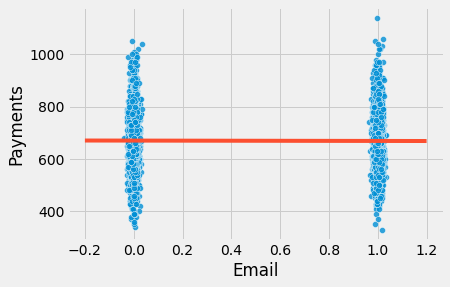

In [4]:
sns.scatterplot("email", "payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

이제 단일 treatment 그룹에서 지불금액이 얼마나 큰 차이를 보이는지 알 수 있습니다. 시각적으로 보면 두 그룹 모두 400에서 1000 정도이며, 0 대비 1에서 약간 낮아진 것 같습니다. 이메일의 효과가 5.00 R$ 또는 10.00 R$ 정도일 경우, 모든 변동성 안에서 메일의 효과를 찾는 것은 어렵지 않습니다.

다행히 회귀는 이러한 변동성을 낮추는 데 도움이 됩니다. 트릭은 통제변수를 추가하는 것입니다. **변수가 outcome의 좋은 예측 변수인 경우, outcome의 분산의 많은 부분을 설명해 줍니다.** 리스크와 신용 한도가 지불금액의 좋은 예측 변수라면 이메일이 지불금액에 미치는 영향을 쉽게 찾을 수 있도록 통제할 수 있습니다. 회귀가 어떻게 작용하는지 기억한다면, 이것은 직관적인 설명일 것입니다. 회귀모형에 변수를 추가하는 것은 treatment를 검토하는 동안 변수를 일정하게 유지하는 것을 의미합니다. 따라서, 비슷한 리스크 점수와 신용 한도가 나온다면, 반응변수 `payments`(지불금액)의 분산은 더 작아야 합니다. 즉, 리스크 점수와 신용한도가 지불금액을 매우 잘 예측한다면, 유사한 리스크 점수와 신용한도를 가진 고객들도 비슷한 지불금액 수준을 가져야 하므로 변동이 적습니다.

![img](./data/img/beyond-conf/y-pred.png)

이를 입증하기 위해 두 단계로 회귀를 분해하는 분할 방법을 사용해 보겠습니다. 우선, treatment(이메일)과 outcome(지불금액)에 대해 추가 통제변수인 신용 한도 및 리스크로 회귀합니다. 둘째, 1단계에서 얻은 outcome(지불금액)에 대한 잔차에 treatment(이메일)의 잔차를 회귀합니다(이것은 순전히 교육을 위한 것이며, 실제로는 이러한 번거로움을 겪을 필요는 없습니다).

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

이렇게 하면 outcome의 분산이 줄어듭니다. 신용한도와 리스크 점수를 지불금액에 회귀시키고 잔차를 얻음으로써, 우리는 원래의 반응변수보다 변동성이 훨씬 적은 새로운 반응변수를 만들 수 있습니다. 마지막 모델은 이 모델을 통해 유효한 표준오차 추정량과 함께 `ATE`를 제공합니다.

또한 단지 호기심으로, treatment를 예측하는 모형이 outcome의 분산을 낮출 수 없어야 한다는 것도 확인할 수 있습니다. 그 이유는 이메일은 원래 무작위이기 때문에 어떤 것도 예측할 수 없기 때문입니다.

In [6]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

model_treatment.summary().tables[1]

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466207
Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


<class 'statsmodels.iolib.table.SimpleTable'>

다음으로 지불금액의 분산이 어떻게 $10807$에서 $5652$로 변했는지 주목해봅시다. 리스크와 신용 한도를 통제할 경우 거의 절반으로 분산이 줄었지만, treatment(이메일)의 분산을 줄이지는 못했습니다. 리스크와 신용한도는 이메일을 전혀 예측하지 않기 못하기 때문에 이 결과는 타당합니다(random의 정의상 어떤 것도 예측하지 않습니다).

자, 이제 훨씬 더 합리적인 것을 볼 수 있습니다. 이 새로운 추정치에 따르면 이메일을 수신한 고객이 이메일을 수신하지 않은 고객보다 평균 4.4장도 더 지불할 것으로 예상됩니다. 또한 각 통제그룹 내에서 분산이 어떻게 더 낮은지 시각화할 수 있습니다.

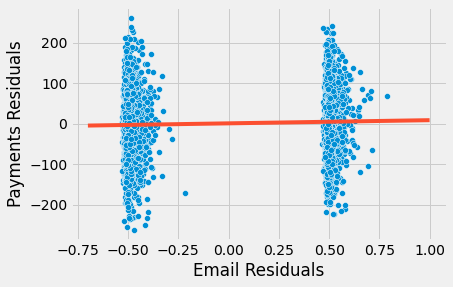

In [7]:
sns.scatterplot("res_email", "res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

말씀드렸듯이, 교육 목적을 위해 이렇게 계산했습니다. 실제로 회귀 모형에 treatment와 control 변수를 추가하면 추정치는 정확히 동일합니다.

In [8]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

결론적으로, outcom을 예측하기 위한 좋은 통제변수가 있을 경우 굳이 교란요인이 아니더라도 모델에 추가하는 것은 좋은 생각일 수 있습니다. treatment 효과 추정치의 분산을 낮추는 데 도움이 됩니다. 이 상황을 인과 그래프에서 어떻게 나타낼 수 있는지 보여줍니다.



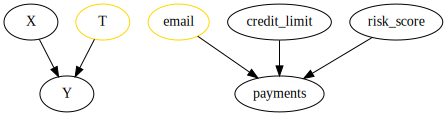

In [9]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Mostly Harmful Controls

두 번째 동기 부여 예시로 두 병원의 약물 검사 시나리오를 생각해 봅시다. 둘 다 특정 질병을 치료하기 위해 신약에 대한 무작위 실험을 진행하고 있으며, 반응변수는 입원 일수입니다. 치료가 효과적이면 환자의 입원 일수가 줄어들 것입니다. 한 병원의 경우, 치료와 관련된 정책으로 임의로 환자의 90%에게 약을 투여하고 10%는 위약을 투여합니다. 다른 병원의 경우, 다른 정책을 가지고 있습니다 : 환자의 10%에게 무작위로 약을 투여하고 90%는 위약을 투여합니다. 환자에게 90%의 진짜 약물과 10%의 위약을 투여하는 병원이 보통 치료하는데 더 심각한 질병인 경우가 많다고 합니다.

In [10]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

hospital  treatment   severity  days
0         1          1  29.686618    82
1         1          1  20.050340    57
2         1          1  20.302399    49
3         0          0  10.603118    44
4         0          0   8.332793    15

랜덤화된 데이터를 다루고 있기 때문에, 첫 번째 직관은 단순히 treatment를 outcome에 대해 회귀하는 것입니다.

In [11]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

하지만 직관에 반하는 결과를 얻었습니다. 어떻게 treatment가 입원 일수를 증가시킬 수 있을까요? 정답은 우리가 두 가지 다른 실험을 하고 있다는 사실에 있습니다. 중증도는 입원일수 증가와 긍정적으로 연관되며, 중증환자가 많은 병원에서 약물을 더 많이 투여하기 때문에, 약물은 입원 일수 증가와 확실히 상관 관계가 있습니다. 두 병원을 함께 살펴보면 $E[Y_0|T=0]<E[Y_0|T=1]$ 가 있습니다. 즉 중증이 아닌 환자가 있는 병원에 치료를 받지 않은 환자가 더 많기 때문에 치료를 받지 않은 환자의 잠재적 결과는 평균적으로 치료를 받은 그룹의 잠재적 결과보다 낮습니다. 즉, 중증도는 환자가 가는 병원과 약을 받을 확률을 결정하는 교란 요인으로 작용합니다.

이러한 결과를 수정하는 방법은 두 가지가 있습니다. 첫 번째는 두 병원 모두 데이터를 사용하는 목적에 어긋나는 것으로 각 병원별로 ATE를 살펴보는 것입니다.


In [12]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [13]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

이 경우, 우리는 직관적인 ATE를 얻었습니다. 약이 사실상 병원 입원 일수를 줄여주는 것 같습니다. 다만, 각 병원을 개별적으로 보고 있기 때문에, 데이터가 충분하지 않습니다. 따라서 통계적으로 유의한 결과를 찾을 수 없습니다.

회귀의 힘을 활용하는 다른 접근법은 모델에 중증도 변수를 포함하여 통제하는 것입니다.

In [14]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

다음 질문은 병원 변수도 모형에 포함시켜야 하는가 입니다. 아무튼 병원이 치료의 원인인 것은 알고 있는 것이군요? 일단 중증도을 통제하고나면 병원 변수는 더 이상 입원 일수와 상관관계가 없습니다. 교란 요인이 되기 위해서는 treatment와 outcome에 모두 원인이 되어야 한다는 것을 알고 있습니다. 이 경우 treatment에만 원인이 되는 변수(병원 변수)가 있으며, 이것을 통제할 경우 분산이 줄어들 수도 있습니다. 그럴까요? 음, 또 사실이 아니네요. 통제요인이 반응변수의 분산을 낮추기 위해서는 병원변수처럼 treatment의 예측변수가 아니라 outcome의 예측변수가 되어야 합니다.

그럼에도 우리는 이 것을 통제하고 싶겠죠? 이 것은 해로울까요? 

In [15]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

놀랍게도, 해로울 수 있습니다!

![img](./data/img/beyond-conf/shocked.png)

중증도 외에 병원을 통제변수로 추가하자 ATE 추정치에 더 많은 편차가 발생했습니다. 어떻게 이런 결과가 나왔을까요? 답은 회귀 계수의 표준오차 공식에 있습니다.

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}
$

이 공식에서 표준오차는 X의 분산에 반비례한다는 것을 알 수 있습니다. 즉, X가 크게 변하지 않는다면, outcome에 미치는 효과를 추정하기 어렵습니다. 이것 직관적으로 이해될 수 있습니다. 극단적으로 약물의 효과를 추정하는 척하고 만 명을 대상으로 검사를 실시하지만, 그 중 한 명만 치료를 받습니다. 이것은 ATE를 찾는 것을 매우 어렵게 만들 것입니다. 우리는 한 명의 개인과 다른 모든 사람을 비교하는 것에 의존해야 할 것입니다. 이를 다르게 표현하면 치료의 효과를 쉽게 찾을 수 있도록 치료에 대한 더 많은 다양성이 필요하다는 것입니다.

즉, 모형에 병원 변수를 추가하면 추정량의 오차가 증가하는 이유는 treatment에는 좋은 예측변수이지만 outcome에는 좋은 예측변수가 아니기 때문입니다(중증도를 통제할 경우). 따라서 treatment를 예측함으로써 분산을 낮추는 효과를 가질 수 있습니다! 위의 회귀모형을 두 단계로 분해하여 확인할 수 있습니다.

In [16]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [17]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.057529091872119076


또한, 제 말을 믿지 마세요! 위의 SE 수식이 참임을 확인할 수 있습니다:

In [18]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.446973767486902


따라서, 결론은 위의 모델의 중증도 변수와 같이 treatment 및 outcome(혼란 요인)과 관련된 통제변수를 추가해야 한다는 것입니다. 또한 교란 요인이 아니더라도 outcome에 좋은 예측변수가 되는 통제변수를 추가해야 합니다. 왜냐하면 이러한 통제변수는 추정치의 분산을 낮추기 때문입니다. 그러나 treatment에 좋은 예측변수인 통제변수는 추정량의 분산을 증가시키므로 추가해서는 안됩니다.

이 상황을 인과관계 그래프에서 어떻게 나타낼 수 있는지 확인해봅시다.

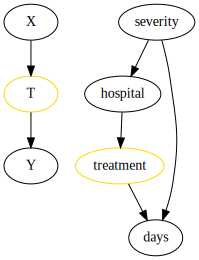

In [19]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g

## Bad Controls - Selection Bias

이메일 예시로 돌아가보겠습니다. 이메일은 무작위로 고객에게 할당되었다는 것을 기억하세요. 우리는 이미 `credit_limit`, `risk_score`이 무엇인지 설명했습니다. 이제 남은 변수들을 살펴봅시다. `opened`는 이메일을 열었는지를 나타내는 더미 변수입니다. `agreement`는 이메일을 수신한 후에 관련 부서에 연락하여 채무협상을 한 경우를 나타내는 더미변수입니다. 다음 모델 중 어떤 모델이 더 적절하다고 생각하십니까? 첫 번째 모형은 treatment(email) + credit_limit + risk_score이고, 두 번째 모형은 첫 번째 모형에 `opened`, `agreement` 변수를 추가한 모형입니다. 

In [20]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [21]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

첫 번째 모형에서 이메일 변수는 통계적으로 유의해보이지만, 두 번째 모형에서는 그렇지 않습니다. 하지만 실제로는 두 번째 모형이 옳은 모형일 수도 있고, treatment(이메일)은 outcome(지불금액)에 효과가 없을 수도 있습니다. 결국 이 모형은 더 많은 요소들을 통제하기 때문에 더 로버스트할까요? 지금쯤 그렇지 않다는 것을 알고 있을 것입니다. 남은 것은 이것이 무엇인지 알아내는 것입니다.

우리는 treatment와 outcome에 모두 원인이 되는 교란 요인을 변수로 추가해야 한다는 것을 알았습니다. 또한 outcome을 매우 잘 예측하는 통제변수를 추가하는 것도 좋은 아이디어라는 것을 알고 있습니다. 이것은 필수는 아니지만, 추가하면 좋습니다. 또한 treatment만을 예측하는 통제변수를 추가하는 것은 좋지 않은 생각이라는 것도 알고 있습니다. 다시 말하지만, 이것은 치명적인 것은 아니지만 피하는 것이 좋습니다. 그럼 `opened`, `agreement`는 어떤 종류의 통제변수일까요? 이 변수는 위에서 설명한 것들에 해당하지 않습니다.

직관적으로 생각해보면 `opened`, `agreement`는 이메일과 확실히 관계가 있습니다. 이메일을 받지 못한 경우에는 이메일을 열 수 없습니다. 또한 agreement도 이메일을 수신한 후에 연락한 경우만 고려한다고 했습니다. **이 변수들은 이메일 변수의 원인은 아닙니다! 대신, 이메일 변수가 이 변수들의 원인입니다!**

어떤 변수를 다루고 있는지 이해해야 할 때마다, 항상 그것들의 인과 그래프에 대해 생각합시다. 여기서 해보죠.

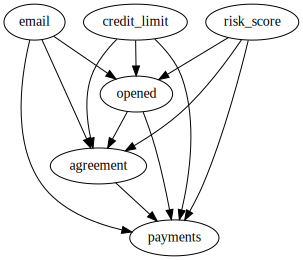

In [22]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

이메일은 랜덤으로 설계되어 있기 때문에 원인이 되는 것은 아무것도 없습니다. 그리고 신용한도와 리스크가 지불금액의 원인이 된다는 것을 알고 있습니다(또는 적어도 믿을 만한 강한 근거가 있습니다). 또한 우리는 이메일이 지불금액의 원인이 된다고 생각합니다. `opened`는 지불금액의 원인이 된다고 생각합니다. 직관적으로 이메일을 연 사람들은 더 기꺼이 연락하고 빚을 갚을 것입니다. `opened`가 지불금액의 원인이 되는 것과 같은 이유로 agreement의 원인이 된다고 생각합니다. 게다가, 이메일은 `opened`의 원인이 된다고 알고 있으며, 다른 리스크와 신용한도를 가진 사람들이 이메일에 대해 다른 open rate를 갖는다는 믿을 만한 이유가 있으므로, 리스크와 신용한도는 `opened`의 원인이 됩니다. 또한 agreement에 관해서도, `opened`가 원인이 될 수 있다고 생각됩니다. 지불금액에 대해 생각해 보면, 다음과 같은 퍼널의 결과를 생각할 수 있습니다.

$
email -> opened -> agreement -> payment 
$

또한 다른 수준의 리스크를 가진 경우 agreement를 수행하는 성향이 다를 것으로 생각되기 때문에 리스크를 agreement의 원인으로 표시했습니다. 이메일과 agreement에 관해서, 어떤 사람들은 이메일의 제목을 읽기만 하면 agreement할 가능성이 높아진다고 주장할 수 있습니다. 요점은 메일을 열지 않고, agreement를 유발할 수도 있다는 것입니다. 

이 그래프에서 알 수 있는 것은 이메일에서 지불금액까지의 인과경로에 opened와 agreement가 모두 있다는 것입니다. 따라서 회귀모형으로 이것들을 통제한다면 "`opened` 및 `agreement`가 고정되었을 때의 이메일의 효과입니다."라고 말할 것입니다. 그러나 둘 다 이메일의 인과 효과의 일부분이기 때문에 고정하고 싶지 않습니다. 대신, 이메일은 agreement의 비율을 높이기 때문에 정확하게 지불금액을 증가시킨다고 주장할 수 있습니다. 이러한 변수를 고정하면 이메일의 실제 효과 중 일부가 제거될 수 있습니다.


잠재적 결과 표기법에서는 무작위화로 인해 $E[Y_0|T=0] = E[Y_0|T=1]$라고 표기할 수 있습니다. 그러나 무작위화를 사용하더라도 agreement를 통제할 경우, treatment와 control를 더 이상 비교할 수 없습니다. 사실, 직관적인 사고를 통해 이 것들이 어떻게 다른지 추측할 수 있습니다:

$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

첫 번째 식은 이메일(빛를 갚을 것을 요청하는 이메일을 수신했는지 유무)과 agreement(이메일을 수신한 후에 관련 부서에 연락하여 채무협상을 한 경우)가 없는 사람이 이메일이 있고 agreement가 없는 사람보다 지불금액이 더 크다라는 것을 분명히 합니다. treatment가 긍정적인 효과가 있다면 **이메일을 받고도** agreement가 없는 사람은 agreement가 없는 사람에 비해 지불 측면에서 더 나쁠 것입니다. 두 번째 식은 이메일이 없고, agreement가 있는 사람이 이메일이 있고 agreement도 있는 사람에 비해 더 나을 수도 있을 것입니다.

처음 읽었을 때 매우 혼란스러울 수 있지만(저에게는 해당), 이해하시기 바랍니다. 필요한 경우 다시 읽어 보십시오. 그러면 opened에 대해서도 비슷한 추론을 할 수 있습니다. 직접 만들어 보세요.

이런 종류의 편향은 너무 만연해서 나름의 명칭을 가지고 있습니다. 교란요인은 공통 원인에 대한 통제 실패에서 오는 편향이지만, **선택 편향은 원인에서 효과까지의 경로 사이에 있는 공통   효과 또는 변수에 대해 통제할 때 발생합니다**. 경험적으로 항상 모형에 Y를 잘 예측할 수 있는 변수 혹은 교란 요인을 항상 포함시켜야 합니다. Treatment만을 잘 예측하는 변수 혹은 treatment와 outcome 사이의 매개변수 또는 treatment와 outcome의 공통 효과인 변수는 항상 제외하십시오.

![img](./data/img/beyond-conf/selection.png)

선택 편향은 너무 만연해서 랜덤화조차 해결할 수 없습니다. 더 나은건, 임의의 데이터에서도 잘못된 조언에 의해 종종 도입된다는 것입니다! 선택 편향을 발견하고 피하려면 기술보다 더 많은 연습이 필요합니다. 종종, 그것들은 아마도 영리한 아이디어 아래에서 나타나서, 발견하는 것을 더욱 어렵게 만듭니다. 다음은 선택 편향의 몇 가지 예입니다.

    1. Adding a dummy for paying the entire debt when trying to estimate the effect of a collections strategy on payments.
    2. Controlling for white vs blue collar jobs when trying to estimate the effect of schooling on earnings
    3. Controlling for conversion when estimating the impact of interest rates on loan duration
    4. Controlling for marital happiness when estimating the impact of children on extramarital affairs
    5. Breaking up payments modeling E[Payments] into one binary model that predict if payment will happen and another model that predict how much payment will happen given that some will: E[Payments|Payments>0]*P(Payments>0)
    
이 모든 아이디어에서 주목할 만한 것은 그것이 얼마나 합리적으로 들리는가에 대한 것입니다. 선택편향은 종종 그러합니다. 이것을 경고로 삼으세요. 사실, 선택편향이 얼마나 나쁜지 알기 전에 여러 번 위의 함정에 빠졌었습니다. 특히 마지막 한 가지는 매우 영리해 보이고 많은 데이터 과학자들의 허를 찌르기 때문에 더 자세히 설명할 가치가 있습니다. 너무 널리 퍼져 있어서, 독자적인 이름을 가지고 있습니다. **The Bad COP**!

### Bad COP

상황은 이렇습니다. 예측하려는 연속형 변수가 있지만 분포가 0이 매우 많습니다. 예를 들어, 고객의 지출 분포를 모형화하려면 감마 분포와 비슷하지만 0이 많습니다.

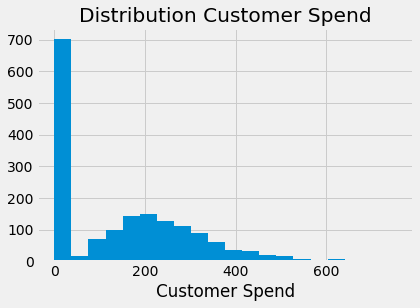

In [23]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

데이터 과학자가 이것을 보았을 때, 머릿속에 떠오르는 첫 번째 생각은 모델링을 두 단계로 나누는 것입니다. 첫 번째는 참여, 즉 $Y>0$일 확률입니다. 이 지출 예에서 이것은 고객의 지출 여부를 결정하는 모형입니다. 두 번째는 참여하기로 결정한 사람들을 위해 Y를 모델링합니다. 이것은 Conditional-on-Positives 효과입니다. 이 경우, 고객이 무엇이든 지출하기로 결정한 후 지출금액입니다. 지출에 대한 T의 효과를 추정하고자 한다면 다음과 같이 정리할 수 있습니다.
 
$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$
 
참여 모델 $P(Y_i>0|T_i)$에는 아무 문제가 없습니다. $T$가 랜덤하게 할당되면 treatment로 인한 지출 확률 증가를 포착할 수 있습니다. 또한 위의 분해에는 문제가 없습니다. 전체 확률의 법칙(law of total probability)에 따라 수학적으로 맞는 말입니다.
 
문제는 COP part를 추정하는 것에 있습니다. **무작위로 할당되더라도 편향될 수 있습니다**. 직관적인 수준에서 일부 단위는 treatment를 받지 않았기 때문에 $0$이라고 생각하는 것은 미친 것이 아닙니다. treatment로 인해 $0$이 되지 않습니다. 반면에, 일부 유닛은 절대로 $0$이 아닙니다. treatment은 outcome을 높일 수 있지만, treatment가 없더라도 그것들은 $0$이 되지 않습니다. 여기서 중요한 것은 이 두 가지 유형의 유닛은 비교할 수 없다는 것을 이해하는 것입니다. 0이 아닌 사람들은 treatment를 받지 않으면 0인 사람들에 비해 $Y_0$이 높습니다. 사실, 후자의 경우 $Y_0 = 0$입니다.
 
이 점에 유의하여 0을 제거하면 treatment그룹과 통제그룹 양쪽에 0이 유지됩니다. 하지만 우리는 treatment를 통해 0에서 0이 아닌 것으로 바뀌는 것들을 통제그룹에서 제거할 것입니다. 이것은 treatment와 대조군을 더 이상 비교할 수 없게 만들 것입니다. 왜냐하면 통제그룹에는 0이 없고 $Y_0$에 높은 값만 포함되는 반면 treatment를 받은 값에는 두 가지 유형의 단위가 모두 포함되기 때문입니다.
 
이제 문제를 직관적으로 이해했으므로 수학적 각도에서 확인해보겠습니다. 이것을 보기 위해 treatment 효과를 나눠보겠습니다. 랜덤 할당에서는 평균의 차이와 같습니다.
 
$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$
 
마지막 식은 $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ 를 더하고 빼서 재배열 하는 것입니다. 이것은 평균의 차이가 두 부분으로 구성된다는 것을 의미합니다. 첫 째, 결과 $y$가 양수일 확률의 차이입니다. 이것은 고객이 지출에 참여할 확률의 증가를 측정하기 때문에 참여 효과라고 불립니다. 둘째, 참여에 따라 결정되는 outcome의 차이인 COP 효과입니다. 지금까지는 좋습니다. 이 식에는 아무 문제가 없습니다. 이것은 수학적 진리입니다. 문제는 우리가 각 부분을 개별적으로 추정하려고 할 때 발생합니다. 

이것은 COP 효과를 분석하면 더욱 분명해집니다.
 
$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$
 
$E[Y_{i0}|Y_{i1}>0]$를 더하고 뺀 후에 두 번째 식이 도출됩니다. COP 효과를 분해할 때 먼저 참가자 하위 모집단에 대한 인과효과를 얻습니다. 이 예시에서, 이것은 무언가를 소비하기로 결정한 사람들의 인과효과가 될 것입니다. 둘 째, treatment에 할당되었을 때 참여하기로 결정한 사람들($E[Y_{i0}|Y_{i1}>0]$)과 treatment 없이도 참여한 사람들($E[Y_{i0}|Y_{i0}>0]$)에 대한 $Y_0$의 차이인 편향 항을 얻습니다. 우리의 경우,이 편향은 아마도 부정적일 것입니다. 왜냐하면 treatment에 할당되었을 때 treatment를 받지 않은 사람들은 treatment $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$ 가 없어도 지출하는 사람들보다 적을 것이기 때문입니다.
 
![img](./data/img/beyond-conf/cop.png)
 
자, COP 편향이 처음에는 매우 직관적이지 않다는 것을 알고 있기에, 시각적인 예를 통해서 한번 살펴보면 좋을 것 같습니다. 마케팅 캠페인을 통해 사람들이 우리 제품에 얼마나 많은 비용을 지출하는지 추정하려고 해요. 이번 마케팅 캠페인은 무작위로 선정되었으므로 교란요인을 걱정할 필요가 없습니다. 이 예에서는, 고객을 2개의 세그먼트(segment)로 나눌 수 있습니다. 첫째, 마케팅 캠페인을 봐야만 우리 제품을 살 수 있는 사람들이 있습니다. 이 고객들을 알뜰 고객이라고 부르겠습니다. 그들은 우리가 그들을 계속 푸쉬하지 않으면 지출을 하지 않습니다. 그리고 캠페인이 없어도 소비하는 고객이 있습니다. 캠페인은 그들이 더 많은 돈을 쓰게 만들지만, 어쨌든 그들은 이미 캠페인에 참여하지 않고 소비를 할 것입니다. 그들을 부자 고객이라고 부르겠습니다. 그림에서 나는 반사실사건(counterfactuals)를 밝은 색상과 파선으로 표시했습니다.

 
![img](./data/img/beyond-conf/cop-ex1.png)
 
캠페인에 대한 ATE를 추정하기 위해, 우리는 무작위화를 진행했기 때문에 treatment를 받은 것과 treatment를 받지 않은 것에 대해 비교하기만 하면 됩니다. 그러나 추정을 두 가지 모델, 즉 $P(Y_i>0|T_i)$를 추정하는 참여 모델과 $E[Y_i|Y_i>0]$ 을 추정하는 COP로 나누는 COP 공식을 사용한다고 가정합니다. 이렇게 하면 지출하지 않은 모든 사람이 분석에서 제거됩니다.
 
![img](./data/img/beyond-conf/cop-ex2.png)
 
이렇게 할 경우 treatment 그룹과 통제 그룹은 더 이상 비교할 수 없습니다. 보시다시피, treatment를 받지 않은 사람들은 이제 캠페인 없이도 소비할 고객들의 일부로만 구성되어 있습니다. 또한 우리는 여기서 편향의 방향을 알 수 있다는 것을 알아두세요. $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ 혹은 $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$ 일 것입니다. 이것은 부자들이 검소한 고객들보다 더 많은 돈을 쓰기 때문에 분명히 부정적입니다. 결과적으로 참가자 모집단만 필터링하면 무작위화로 인해 처음에는 편향이 없더라도 ATE에 대한 추정치가 편향됩니다. 저는 이것이 당신이 전염병처럼 COP를 피하도록 설득하기를 진심으로 바랍니다. 저는 너무 많은 데이터 과학자들이 이것이 가져오는 문제들을 알지 못한 채 이 별도의 추정을 하고 있는 것을 봅니다.

선택 편향을 마무리하기 위해, 우리는 항상 treatment와 outcome 사이에 있거나 outcome과 treatment의 공통적인 효과인 변수를 통제하지 말아야 한다는 것을 스스로에게 상기시킬 필요가 있습니다. 그래프를 통해 잘못된 통제 예시를 보면 다음과 같습니다.

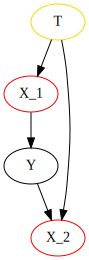

In [24]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

## Key Ideas

해당 챕터에서 인과관계를 확인하기 위해 우리의 모델에 변수를 추가해야 하는지, 그렇지 않은지를 살펴보았습니다. outcome에 대해 좋은 예측변수는 $T$(교란요인이 아닌)를 예측하지 않더라도 모형에 추가해야 합니다. 이는 $Y$를 예측하면 분산이 낮아지고 인과 관계를 추정할 때 통계적으로 유의미한 결과가 나타날 가능성이 높아지기 때문입니다. 다음으로, 우리는 treatment를 예측하지만 outcome을 예측하지 않는 변수를 추가하는 것이 좋지 않다는 것을 알았습니다. 이러한 변수들은 treatment의 변동성을 줄여 인과효과를 찾기 어렵게 만듭니다. 마지막으로 선택 편향에 대해 살펴보았습니다. 이것은 treatment에서 outcome 또는 treatment와 outcome의 공통적인 효과인 변수에 대한 인과 경로의 변수를 통제할 때 발생하는 편향입니다.

## References

이 책을 쓰기 위해 Joshua Angrist, Alberto Abadie, Christopher Walters의 대단한 계량 경제학 수업 자료를 많이 참고했습니다. 해당 자료에 있는 대부분의 아이디어는 전미경제학회(American Economic Association)의 수업에서 가져왔어요. 이렇게 좋은 참고자료를 보는 것이 2020년의 힘든 한 해를 지탱하게 만들어준 원동력이었다고 생각해요.

* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

또한, Angrist의 정말 좋은 책들을 참고자료에 넣고 싶어요. 해당 저자가 쓴 책들은 계량경제학(Econometrics) 또는 '메트릭스(Metrics, 계량적 분석)'가 매우 유용할 뿐만 아니라 매우 흥미롭다는 걸 알려주었어요.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering ‘Metrics](https://www.masteringmetrics.com/)

마지막으로 참고한 자료는 Miguel Hernan과 Jamie Robins의 책입니다. 이 책들은 제가 대답해야 했던 까다로운 인과적인 질문에서 신뢰할 수 있는 동반자 같은 존재였어요.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](https://matheusfacure.github.io/python-causality-handbook/_images/poetry.png)

해당 챕터에 사용된 데이터는 Susan Athey과 Stefan Wager [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf)에서 제공하고 있습니다.

## Contribute

Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요.
여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true)를 방문해주세요. 
만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 [이슈 페이지](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/issues)를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, [한국어 번역 자료](https://github.com/CausalInferenceLab/Causal-Inference-with-Python/stargazers)와 [해당 번역본의 원서](https://github.com/matheusfacure/python-causality-handbook/stargazers)에 star 부탁드립니다!